### Introduction to ML
### Developing a Reverse Image Search System for Ceramic Tiles

## 1. Data Loading

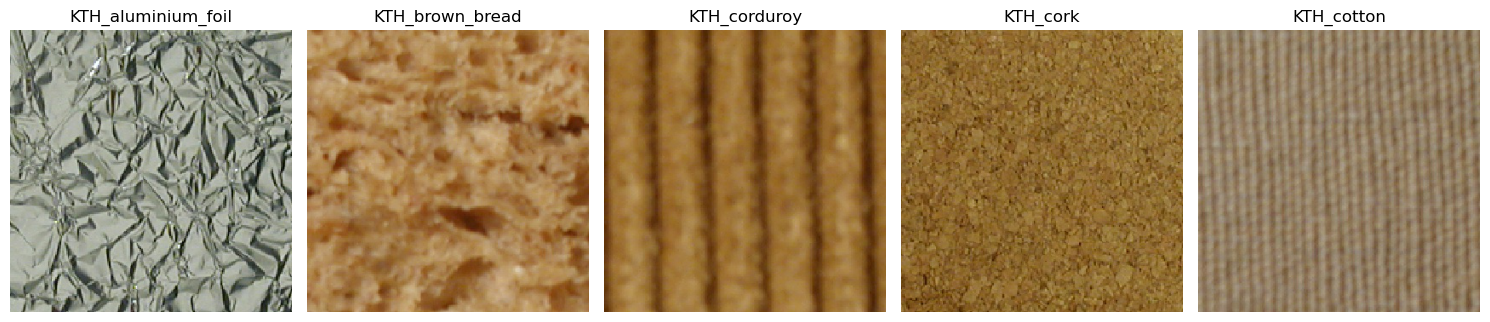

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set the path to the directory where the dataset is stored
dataset_directory = './Textures-Dataset/train'

# Initialize a counter for the number of classes processed
num_classes = 0

# Initialize a figure for plotting
plt.figure(figsize=(15, 10))

# Display one image from each class in both vertical and horizontal orientations
for class_name in os.listdir(dataset_directory):
    class_dir = os.path.join(dataset_directory, class_name)
    
    # Check if it's a directory
    if os.path.isdir(class_dir):
        # Get the first image in the directory
        image_name = os.listdir(class_dir)[0]
        image_path = os.path.join(class_dir, image_name)
        
        # Load the image
        image = Image.open(image_path)

        # Increment the class counter
        num_classes += 1

        # Add a subplot for the original image
        plt.subplot(2, 5, num_classes)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')

        # Check if we have processed 5 classes
        if num_classes == 5:
            break

# Adjust subplot parameters for a nicer layout
plt.tight_layout()
plt.show()

## 2. Feature Extraction:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the device
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(3, 32, 3, padding=1)  # Adjust input channels to 3 for RGB
        self.conv2=nn.Conv2d(32, 64, 3, padding=1)  # Adjusting input channels
        self.pool=nn.MaxPool2d(2, 2)
        
        # Calculate the output size after convolutional layers dynamically
        self.fc_input_size=64*16*16  # Update this size based on your specific case
        
        self.fc1=nn.Linear(self.fc_input_size, 600)
        self.fc2=nn.Linear(600, 120)
        self.fc3=nn.Linear(120, 64)
        self.dropout=nn.Dropout(0.25)

    def forward(self, x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        
        # Calculate the output shape after convolutions and poolings
        x=x.view(-1, self.fc_input_size)  # Adjust according to the calculated size
        
        x=F.relu(self.fc1(self.dropout(x)))
        x=F.relu(self.fc2(self.dropout(x)))
        x=self.fc3(x)
        return x


net=Net().to(device)  # Move the model to the specified device


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define data transformations
transform=transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load training dataset
train_dataset=datasets.ImageFolder(root='./Textures-Dataset/train', transform=transform)
train_loader=DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load validation dataset
val_dataset=datasets.ImageFolder(root='./Textures-Dataset/valid', transform=transform)
val_loader=DataLoader(val_dataset, batch_size=64, shuffle=False)


## 3. Model Validation

In [5]:
import torch.optim as optim
import warnings 

# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Lists for saving training and validation history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    # Training
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.3f}, Train Accuracy: {train_accuracies[-1]:.2f}, Val Loss: {val_losses[-1]:.3f}, Val Accuracy: {val_accuracies[-1]:.2f}')


Epoch 1, Train Loss: 3.018, Train Accuracy: 19.98, Val Loss: 2.066, Val Accuracy: 40.21
Epoch 2, Train Loss: 1.651, Train Accuracy: 48.65, Val Loss: 1.203, Val Accuracy: 61.98
Epoch 3, Train Loss: 1.047, Train Accuracy: 66.44, Val Loss: 0.892, Val Accuracy: 71.94
Epoch 4, Train Loss: 0.814, Train Accuracy: 73.77, Val Loss: 0.746, Val Accuracy: 76.27
Epoch 5, Train Loss: 0.597, Train Accuracy: 81.55, Val Loss: 0.626, Val Accuracy: 79.56
Epoch 6, Train Loss: 0.494, Train Accuracy: 84.06, Val Loss: 0.620, Val Accuracy: 79.86
Epoch 7, Train Loss: 0.436, Train Accuracy: 86.25, Val Loss: 0.610, Val Accuracy: 81.98
Epoch 8, Train Loss: 0.361, Train Accuracy: 88.67, Val Loss: 0.554, Val Accuracy: 82.07
Epoch 9, Train Loss: 0.285, Train Accuracy: 90.93, Val Loss: 0.517, Val Accuracy: 84.12
Epoch 10, Train Loss: 0.252, Train Accuracy: 92.30, Val Loss: 0.566, Val Accuracy: 82.00


## 4. Result Visualization

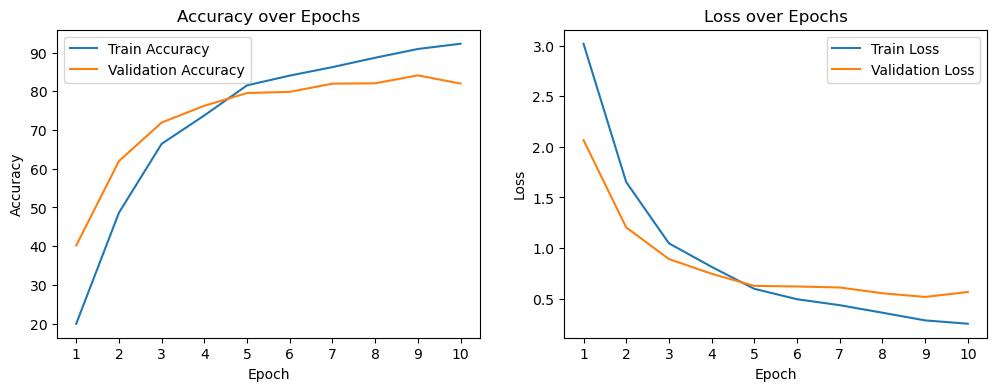

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 4))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(np.arange(1, len(train_accuracies) + 1, step=1))  # Set x-axis ticks to integer values

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(1, len(train_losses) + 1, step=1))  # Set x-axis ticks to integer values

plt.show()


## 5. Retrieving and Displaying Results:

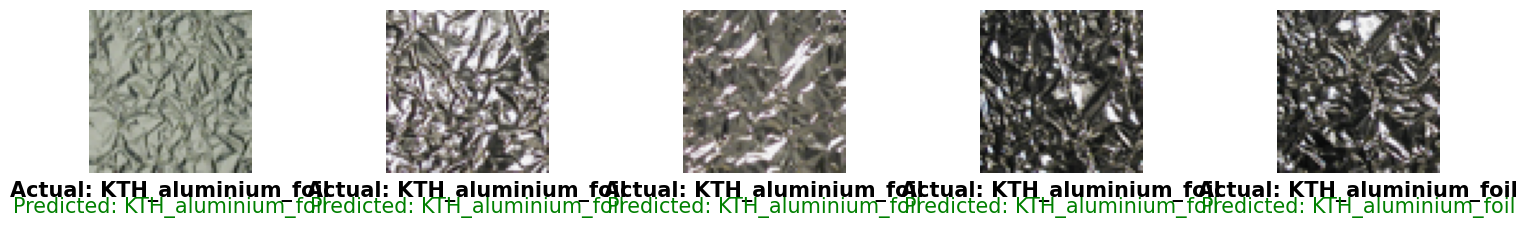

In [11]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set the path to the directory where the dataset is stored
dataset_directory = './Textures-Dataset/train'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the original dataset directory (for prediction)
predict_dataset = datasets.ImageFolder(root=dataset_directory, transform=transform)
predict_loader = DataLoader(predict_dataset, batch_size=64, shuffle=False)

# Function to predict labels on the initial dataset
def predict_on_dataset(net, predict_loader, device):
    net.eval()
    predicted_labels = []
    with torch.no_grad():
        for data in predict_loader:
            inputs, _ = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            _, predictions = torch.max(outputs, 1)
            predicted_labels.extend(predictions.cpu().numpy())
    return predicted_labels

# Predict labels for the images in the initial dataset
predicted_labels = predict_on_dataset(net, predict_loader, device)

# Visualize the predicted labels against the actual images
plt.figure(figsize=(15, 10))
images_so_far = 0

for i, (inputs, labels) in enumerate(predict_loader):
    for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(2, 5, images_so_far)
        ax.axis('off')

        # Add a border around the images
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)

        # Display the original image on which the search was performed
        img_path = predict_dataset.samples[i * 64 + j][0]
        img = Image.open(img_path)
        img = img.resize((64, 64))  # Resize to match the model's input size
        plt.imshow(img)
        
        true_label = f'Actual: {val_dataset.classes[labels[j]]}'
        pred_label = f'Predicted: {val_dataset.classes[predicted_labels[i * 64 + j]]}'
        pred_color = 'red' if predicted_labels[i * 64 + j] != labels[j] else 'green'

        # Position the text below the image and increase the font size
        plt.text(0.5, -0.05, 
                 true_label, 
                 ha='center', 
                 transform=ax.transAxes, 
                 fontsize=15, 
                 verticalalignment='top', 
                 weight='bold')
        plt.text(0.5, -0.15, 
                 pred_label, 
                 ha='center', 
                 color=pred_color, 
                 transform=ax.transAxes, 
                 fontsize=15, 
                 verticalalignment='top')

        if images_so_far == 5:  # Display 5 images for visualization
            break
    if images_so_far == 5:
        break

plt.tight_layout()
plt.show()
